In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

# Overview

In this project, I build an algorithm to predict whether a particular in lending club will be a success or a failure. A successful loan is a loan that is fully paid off. A failure loan is a loan either in default state or charged off state, where there is no reasonable expectation that the loan will be paid off. 

In [2]:

# Load all the data 
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer
df = pd.read_csv('/Volumes/mac/Work/JobHunt/Incubator/ipynb/LoanStats3a_securev1.csv',skiprows=1,low_memory=False)
dfb = pd.read_csv('/Volumes/mac/Work/JobHunt/Incubator/ipynb/LoanStats3b_securev1.csv',skiprows=1,low_memory=False)
dfc = pd.read_csv('/Volumes/mac/Work/JobHunt/Incubator/ipynb/LoanStats3c_securev1.csv',skiprows=1,low_memory=False)
dfd = pd.read_csv('/Volumes/mac/Work/JobHunt/Incubator/ipynb/LoanStats3d_securev1.csv',skiprows=1,low_memory=False)

In [3]:
totdf = df
totdf = df.append(dfb)
totdf = totdf.append(dfc)
totdf = totdf.append(dfd)

In [4]:

pd.options.mode.chained_assignment = None
# success: 1, failure: -1, others: 0, questionable: 0.5
totdf['stat'] = pd.Series(np.zeros(np.shape(totdf['id'])))

success = ['Fully Paid']
failure = ['Charged Off','Default']
question = ['In Grace Period','Late (16-30 days)','Late (31-120 days)']

for i in success:
    totdf.stat[totdf.loan_status == i] = 1

for i in failure:
    totdf.stat[totdf.loan_status == i] = -1

for i in question:
    totdf.stat[totdf.loan_status == i] = 0.5

# ONLY look at the data for failure and success, no questionable or other type
CleanUpRecord = totdf.loc[(totdf.stat==1)|(totdf.stat==-1)]
df = CleanUpRecord
df.stat[df.stat == -1] =0

In [5]:
# Define relevant features
relevant = [ 'annual_inc',
             'dti', 
             'emp_length',
             'fico_range_high',
             'fico_range_low',
             'home_ownership',
             'loan_amnt',
             'open_acc',
             'policy_code',
             'pub_rec',
             'sub_grade',
             'term',
             'total_acc',
             'earliest_cr_line',
             'issue_d'
#             'purpose',
            ]

X = df[relevant]
y = df['stat']


# feature engineering. 

In [6]:
from sklearn.base import BaseEstimator,RegressorMixin,TransformerMixin
class List2Dict_Transformer(BaseEstimator,TransformerMixin):
    '''
    Expects a data-frame object. 
    Change the DataFrame to a list of dictionaries.
    'sub_grade'   ===> int (10-88)
    'emp_length'  ===> int (0-10)
    'term'        ===> int (36-60)
    'issue_d & earliest_cr_line'
                  ===> int (length of credit history to date)
    '''
    def __init__(self, str_keys=[], live=0):
        self.str_keys = str_keys
        self.live = live
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        from datetime import datetime
        grademap = {'A':10,"B":20,"C":30,"D":40,"E":50,"F":60,"G":70,"H":80}
        X_dict = []
        X_keys = X.columns
        for i in xrange(len(X)):
            x_dict = {}
            for key in X_keys:
                if key in self.str_keys:
                    x_dict[key + '_' + X[key].iloc[i]] = 1
                elif key == u'emp_length':
                    if self.live == 0:
                        recode = X[key].iloc[i][0].lower()
                        if recode == 'n':
                            x_dict[key] = -1
                        elif recode == '<':
                            x_dict[key] = 0
                        else:
                            x_dict[key] = int(X[key].iloc[i][:2])
                    else:
                        if np.isnan(X[key].iloc[i]):
                            x_dict[key] = -1
                        else:
                            x_dict[key] = X[key].iloc[i] /12    
                elif key == 'sub_grade':
#                     print X[key].iloc[i][0]
                    base = grademap[X[key].iloc[i][0]]
                    x_dict[key] = base + int(X[key].iloc[i][1])
                elif key == 'term' and self.live==0:
                    x_dict[key] = int(X[key].iloc[i][:3])
                elif key in ['issue_d', 'earliest_cr_line']:
                    if self.live==1 and key == 'earliest_cr_line':
                        x_dict[key] = datetime.strptime(X[key].iloc[i][:10],'%Y-%m-%d')
                    else:
                        x_dict[key] = datetime.strptime(X[key].iloc[i],'%b-%Y')
                else:
                    x_dict[key] = float(X[key].iloc[i])
            x_dict['CreditLength'] = (x_dict['issue_d'] - x_dict['earliest_cr_line']).days
            del x_dict['issue_d']
            del x_dict['earliest_cr_line']
            X_dict.append(x_dict)
        return X_dict


# pandas data frame to a list of dictionaries, and to Vectors

In [7]:
List2DictT = List2Dict_Transformer(str_keys=['home_ownership'])
X_trans = List2DictT.fit_transform(X)
from sklearn.feature_extraction import DictVectorizer
DictVectorT = DictVectorizer(sparse=False)
X_vect = DictVectorT.fit_transform(X_trans)

In [8]:
# save the transformers
import dill
with open('./List2DictT.pkl','wb') as out_strm:
    dill.dump(List2DictT,out_strm)
    
with open('./DictVectorT.pkl','wb') as out_strm:
    dill.dump(DictVectorT,out_strm)

In [9]:
# save the data after the transformers
with open('./X_vect.pkl','wb') as out_strm:
    dill.dump(X_vect,out_strm)

# Split the data and rebalance the data

In [10]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2)

In [11]:
# rebalance the data
def rebalanceXy(X,y):
    # permute the data, just in case it is order:
    import numpy as np
    y = np.array(y)
    X = np.array(X)
    perm = np.random.permutation(len(y))
    X = X[perm]
    y = y[perm]
    # determine which one is not balanced
    y_uniq = np.unique(y)
    if len(y[y==y_uniq[0]]) < len(y)/2:
        y_less,y_more = y_uniq[0], y_uniq[1]
    else:
        y_less,y_more = y_uniq[1], y_uniq[0]
    
    n_less = len(y[y==y_less])
    n_more = len(y[y==y_more])
    # rebalance
    # The idea is to select all the y_less data, but not all the y_more data. 
    
    yy_less = y[y==y_less]
    XX_less = X[y==y_less]
    
    yy_more = y[y==y_more]
    XX_more = X[y==y_more]
    
    XX_reblance = []
    yy_reblance = []
    Xy_reblance = []
    for i in xrange(n_more/n_less + 1):
        St = i*n_less
        Ed = (i+1)*n_less
        if Ed <= n_more:            
            XX_tmp = np.append(XX_more[St:Ed],XX_less,0)
            yy_tmp = np.append(yy_more[St:Ed],yy_less,0)
            perm = np.random.permutation(n_less*2)
            Xy_reblance.append([XX_tmp[perm], yy_tmp[perm]])
        else:
            Diff = np.random.random_integers(0,n_more-1,Ed-n_more)
            np.append(XX_more[St:Ed], XX_more[Diff],0)
            
            XX_tmp = np.append(np.append(XX_more[St:Ed], XX_more[Diff],0), XX_less,0)
            yy_tmp = np.append(np.append(yy_more[St:Ed], yy_more[Diff],0), yy_less,0)
            perm = np.random.permutation(n_less*2)
            Xy_reblance.append([XX_tmp[perm], yy_tmp[perm]])
        
    return Xy_reblance

In [12]:
Xy_train_bal = rebalanceXy(X_train,y_train)

In [13]:
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

TotGNBMOD = []
TotGBGMOD = []
TotLGRMOD = []
for i in xrange(len(Xy_train_bal)):
    XX_bal = Xy_train_bal[i][0]
    yy_bal = Xy_train_bal[i][1]
    
    gnb = GaussianNB()
    y_pred = gnb.fit(XX_bal, yy_bal)
    TotGNBMOD.append(gnb)
    
    # Random forest is not leftover to reduce the memory fingerprint of the model
    # RFfit =RandomForestClassifier(n_estimators=300)
    # RFfit.fit(XX_bal,yy_bal)
    
    # Gradient boosting paramenter is tuned using Gridsearch
    clf=GradientBoostingClassifier(n_estimators=1000,max_depth=5,
                               learning_rate=0.05,max_features='sqrt')
    clf.fit(XX_bal,yy_bal)
    TotGBGMOD.append(clf)
    
    clf2=LogisticRegression()
    clf2.fit(XX_bal,yy_bal)
    TotLGRMOD.append(clf2)

In [14]:
from sklearn.linear_model import LogisticRegression
# combine all the models using logistic regression
y_cmb = []
for RF in TotGNBMOD:
    y_cmb.append(RF.predict_proba(X_train)[:,0])

for RF in TotGBGMOD:
    y_cmb.append(RF.predict_proba(X_train)[:,0])

for RF in TotLGRMOD:
    y_cmb.append(RF.predict_proba(X_train)[:,0])

import numpy as np
FinalLGR = LogisticRegression(class_weight={0:0.8,1:0.2})
FinalLGR.fit(np.array(y_cmb).T,y_train)

TotModes = TotGNBMOD + TotGBGMOD + TotLGRMOD + [FinalLGR]


In [15]:
import dill
with open('TotModes.pkl','wb') as out_strm:
    dill.dump(TotModes,out_strm)

# Evaluation the mode on the test data

In [16]:
def Compute_TPFN(y_pred,y_true):
    '''
    Custom method to compute the confusion matrix
    '''
    df = pd.DataFrame(columns=('y_pred','y_true','count'))
    df['y_pred'] = pd.Series(y_pred)
    df['y_true'] = pd.Series(np.array(y_true))
    df['count'] = 1
    return df.groupby(['y_pred','y_true']).count()

In [17]:
y_cmb_test = []
for RF in TotGNBMOD:
    y_cmb_test.append(RF.predict_proba(X_test)[:,0])

for RF in TotGBGMOD:
    y_cmb_test.append(RF.predict_proba(X_test)[:,0])

for RF in TotLGRMOD:
    y_cmb_test.append(RF.predict_proba(X_test)[:,0])

(array([  206.,  1601.,  3178.,  3796.,  4026.,  4362.,  4795.,  5699.,
         6228.,  3497.]),
 array([ 0.0087329 ,  0.10688845,  0.20504399,  0.30319954,  0.40135509,
         0.49951064,  0.59766619,  0.69582173,  0.79397728,  0.89213283,
         0.99028838]),
 <a list of 10 Patch objects>)

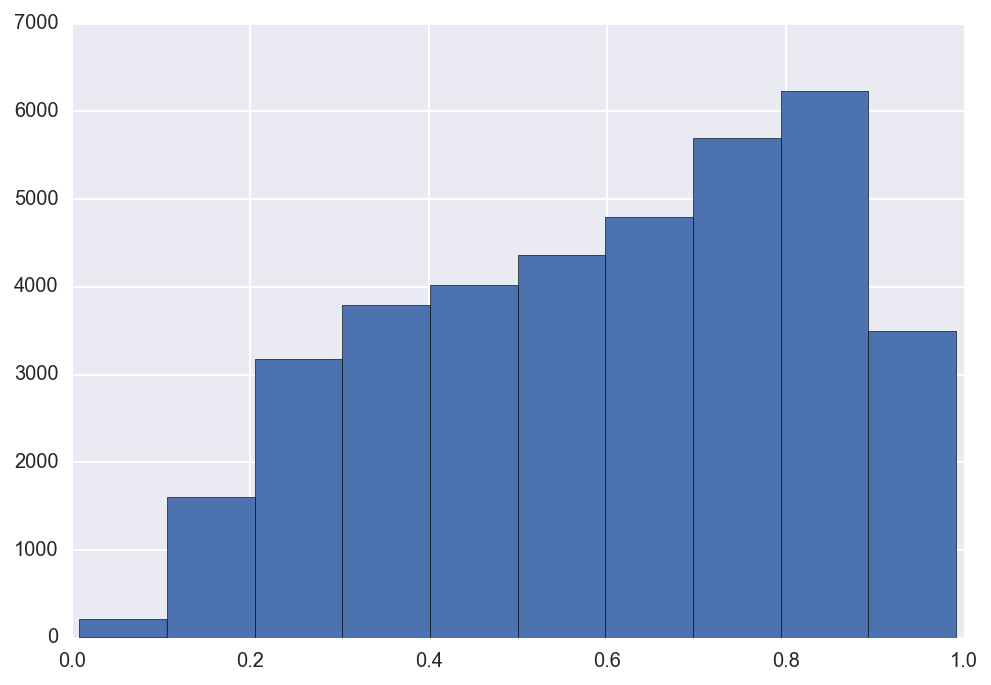

In [69]:
# plt.hist(np.array(y_cmb_test).T[:,14])
plt.hist(y_score)

## ROC curve

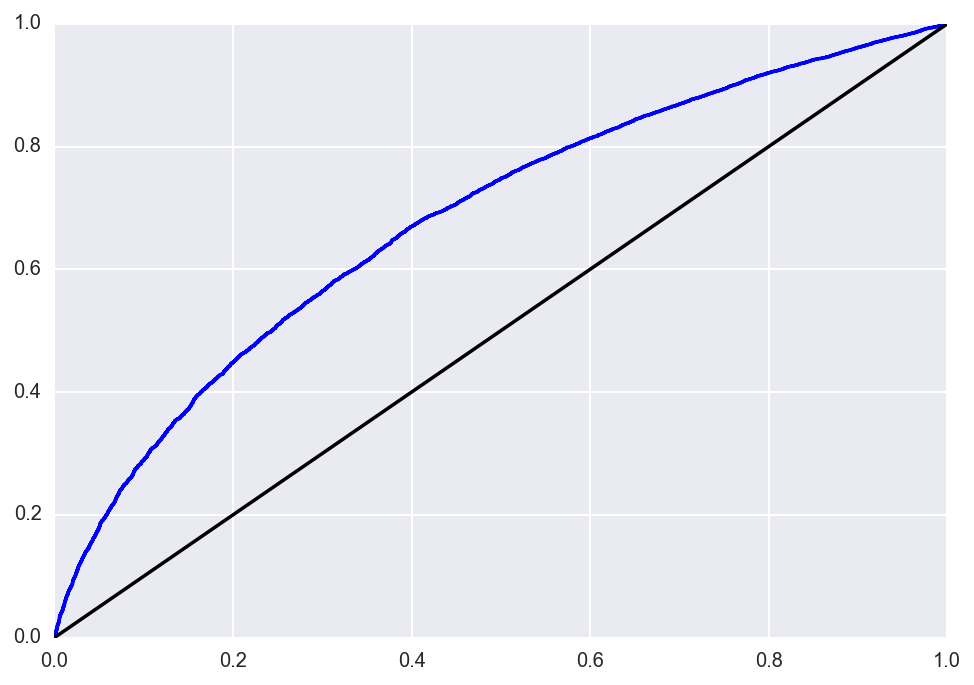

In [20]:
from sklearn.metrics import roc_curve
y_score = FinalLGR.predict_proba(np.array(y_cmb_test).T)[:,1]
a,b,c=roc_curve(y_test,y_score)
import matplotlib.pyplot as plt
plt.plot(a,b,'b')
plt.plot(a,a,'k-')
plt.show()

## confusion matrix

In [21]:
y_pred_cmb_train = FinalLGR.predict(np.array(y_cmb).T)
y_pred_cmb_test  = FinalLGR.predict(np.array(y_cmb_test).T)

print 'Train ',Compute_TPFN(y_pred_cmb_train,y_train)
print 'Test ' ,Compute_TPFN(y_pred_cmb_test,y_test)


Train                 count
y_pred y_true       
0      0       17838
       1       32956
1      0        8759
       1       89996
Test                 count
y_pred y_true       
0      0        3762
       1        9067
1      0        3032
       1       21527


The model generated comparable result on the test and training datasets.

# Retrain over the whole dataset

In [22]:
Xy_whole_bal = rebalanceXy(X_vect,y)

In [23]:
FinalTotGNBMOD = []
FinalTotGBGMOD = []
FinalTotLGRMOD = []
for i in xrange(len(Xy_whole_bal)):
    XX_bal = Xy_whole_bal[i][0]
    yy_bal = Xy_whole_bal[i][1]
    
    gnb = GaussianNB()
    y_pred = gnb.fit(XX_bal, yy_bal)
    FinalTotGNBMOD.append(gnb)
    
    clf=GradientBoostingClassifier(n_estimators=1000,max_depth=5,
                               learning_rate=0.05,max_features='sqrt')
    clf.fit(XX_bal,yy_bal)
    FinalTotGBGMOD.append(clf)
    
    clf2=LogisticRegression()
    clf2.fit(XX_bal,yy_bal)
    FinalTotLGRMOD.append(clf2)

In [24]:
y_cmb_tot = []
for RF in FinalTotGNBMOD:
    y_cmb_tot.append(RF.predict_proba(X_vect)[:,0])

for RF in FinalTotGBGMOD:
    y_cmb_tot.append(RF.predict_proba(X_vect)[:,0])

for RF in FinalTotLGRMOD:
    y_cmb_tot.append(RF.predict_proba(X_vect)[:,0])

import numpy as np
FinalCmbLGR = LogisticRegression(class_weight={0:0.8,1:0.2})
FinalCmbLGR.fit(np.array(y_cmb_tot).T,y)

LogisticRegression(C=1.0, class_weight={0: 0.8, 1: 0.2}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0)

## Confusion matrix

In [25]:
y_pred_cmb_tot  = FinalCmbLGR.predict(np.array(y_cmb_tot).T)
y_prob_cmb_tot  = FinalCmbLGR.predict_proba(np.array(y_cmb_tot).T)
print 'Tot ' ,Compute_TPFN(y_pred_cmb_tot,y)

Tot                  count
y_pred y_true        
0      0        22139
       1        43206
1      0        11252
       1       110340


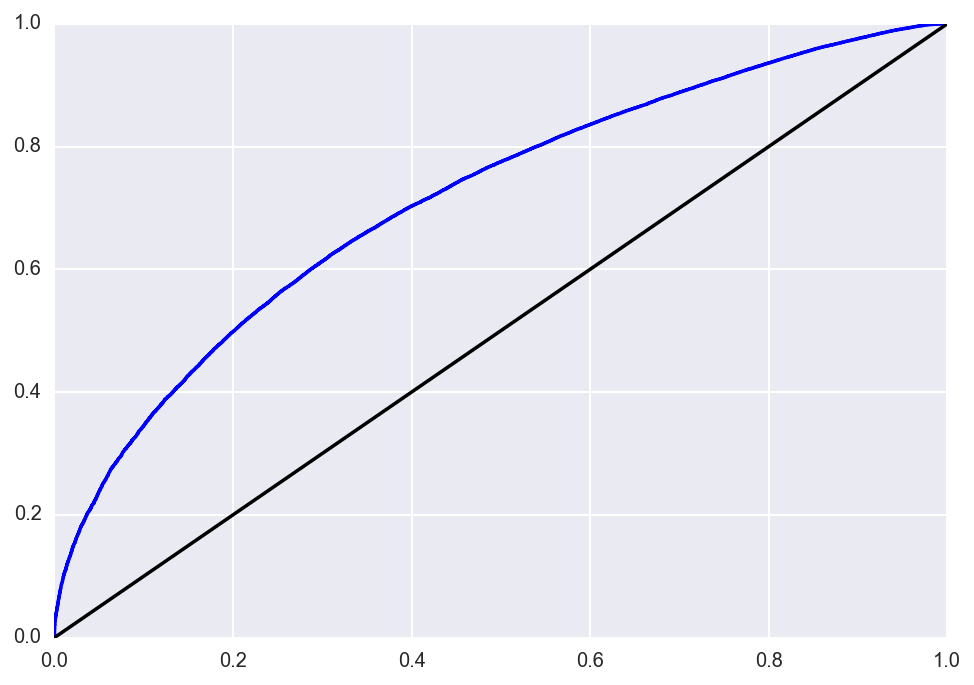

In [83]:
from sklearn.metrics import roc_curve
a,b,c=roc_curve(y,y_prob_cmb_tot[:,1])
import matplotlib.pyplot as plt
plt.plot(a,b,'b')
plt.plot(a,a,'k-')
plt.show()

# Demos used in the web deployment

## demo 1

In [28]:
# demo1
demo1=df.iloc[222]

# demo2
N = 40
print y_prob_cmb_tot[(y_prob_cmb_tot[:,1] > 0.8) * (X_vect[:,-3] >40)][N], y[(y_prob_cmb_tot[:,1] > 0.8)* (X_vect[:,-3] >40)].iloc[N]
demo2=df[(y_prob_cmb_tot[:,1] > 0.8) * (X_vect[:,-3] >40)].iloc[N]
#demo3
N = 30
print y_prob_cmb_tot[(y_prob_cmb_tot[:,1] < 0.3) * (X_vect[:,-3] <20)][N], y[(y_prob_cmb_tot[:,1] < 0.3)* (X_vect[:,-3] <20)].iloc[N]
demo3=df[(y_prob_cmb_tot[:,1] < 0.3)* (X_vect[:,-3] <20)].iloc[N]
# demo4
N = 10452
print y_prob_cmb_tot[(y_prob_cmb_tot[:,1] > 0.4) * (y_prob_cmb_tot[:,1] < 0.6)][N], y[(y_prob_cmb_tot[:,1] > 0.4)*(y_prob_cmb_tot[:,1] < 0.6)].iloc[N]
demo4=df[(y_prob_cmb_tot[:,1] > 0.4) * (y_prob_cmb_tot[:,1] < 0.6)].iloc[N]

[ 0.18841688  0.81158312] 1.0
[ 0.88965423  0.11034577] 0.0
[ 0.54756627  0.45243373] 1.0


# The distribution of scores for different outcome

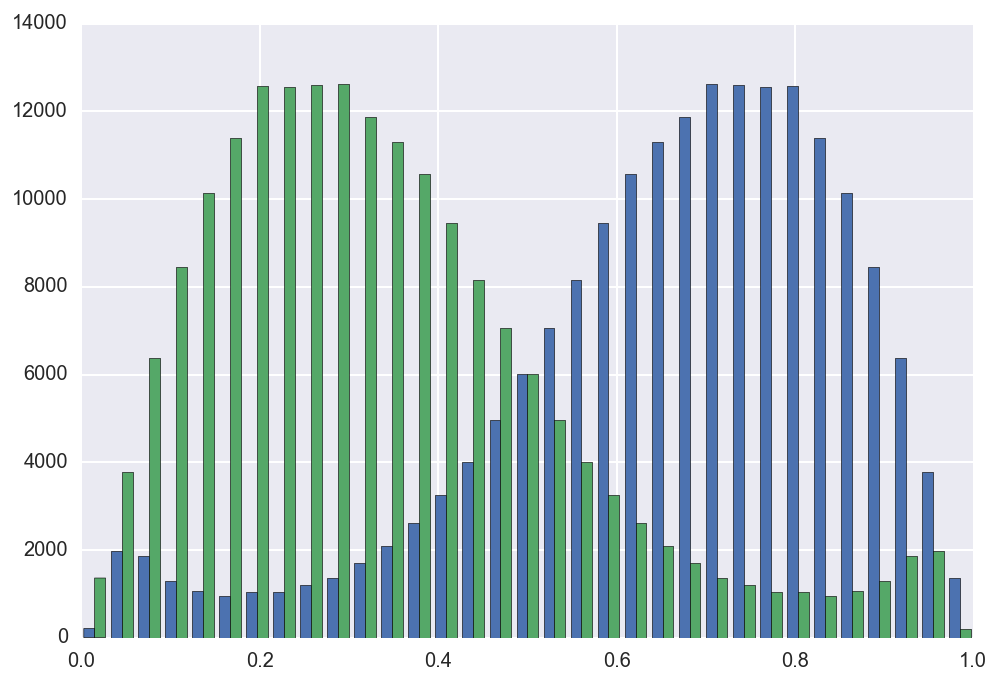

In [42]:
# plot about the probabilty prediction of loans with 1, and 0. 
plt.hist(y_prob_cmb_tot,bins= 33)
plt.show()

# distribution of c1 probability

In [99]:
StatsByGrade = pd.DataFrame()
StatsByGrade['prob'] = np.array((y_prob_cmb_tot[:,1]))*100
StatsByGrade['sub_grade']= np.array(df['sub_grade'])
StatsByGrade['outcome'] = np.array(y.values * 1.0)

MedianScore =StatsByGrade.groupby(['sub_grade']).median()

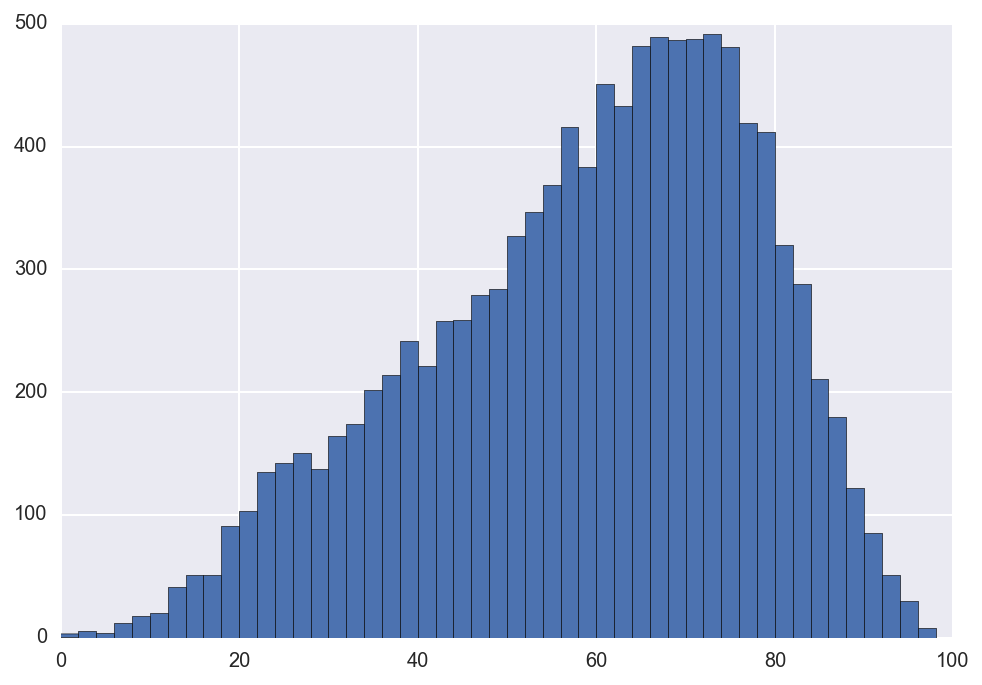

In [101]:
plt.hist(StatsByGrade[(StatsByGrade.sub_grade=='C1') ].prob.values,range=(0,100),bins= 50)
plt.show()

In [102]:
NN = 20
bins = np.linspace(0,100,NN+1)

Data = StatsByGrade
counts = np.zeros(NN)
for i in range(NN):
    counts[i] = Data[(Data.prob>= bins[i]) * (Data.prob< bins[i+1])].outcome.mean()

grades = pd.unique(StatsByGrade['sub_grade'])
ScoreByGrade = pd.DataFrame(columns=[grades])
binN = 20
bins = np.linspace(0,100,binN+1)
for grade in grades:
    NN = sum(StatsByGrade['sub_grade']==grade)*1.0/100
    (a,b)=np.histogram(StatsByGrade[StatsByGrade['sub_grade']==grade].prob,bins=bins)
    ScoreByGrade[grade]=a/NN
ScoreByGrade.index = b[1:]  
ScoreByGrade['PayoffProba'] = counts

In [ ]:
import dill
with open('ScoreByGrade.pkl','wb') as out_strm:
    dill.dump(ScoreByGrade,out_strm)
with open('MedianScore.pkl','wb') as out_strm:
    dill.dump(MedianScore,out_strm)

# Score versus Probability

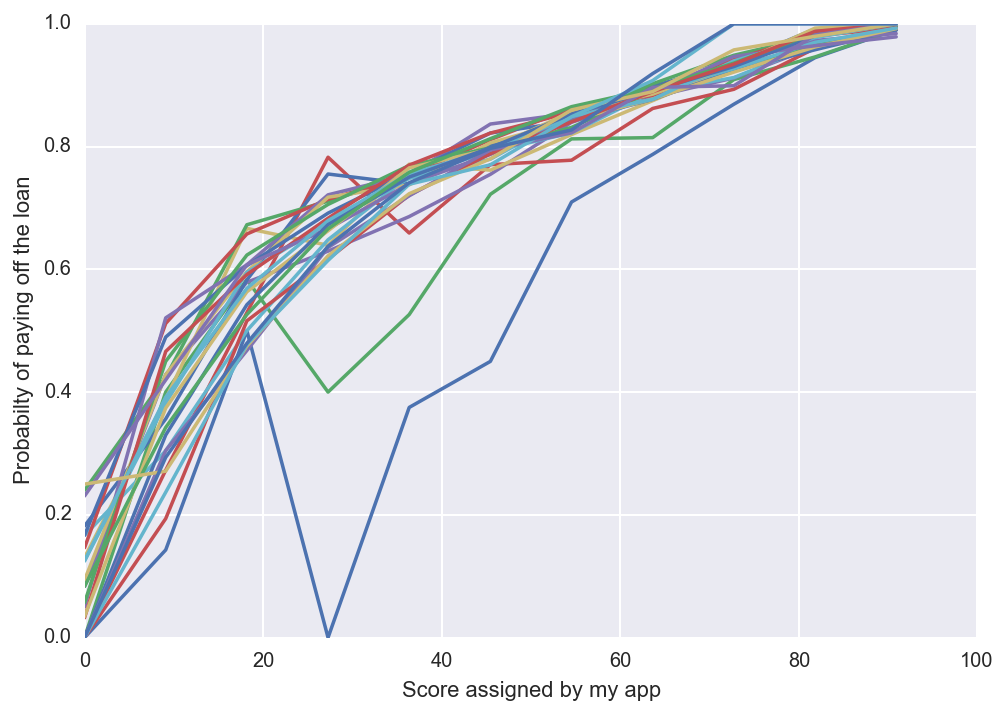

In [105]:
# Count by Probability
NN = 11
bins = np.linspace(0,100,NN+1)
for Grade in ['A1','A2','A3','A4','A5',
              'B1','B2','B3','B4','B5',
              'C1','C2','C3','C4','C5',
              'D1','D2','D3','D4','D5',
              'E1','E2','E3','E4','E5']:
    Data = StatsByGrade[StatsByGrade.sub_grade == Grade]
    counts = np.zeros(NN)
    for i in range(NN):
        counts[i] = Data[(Data.prob>= bins[i]) * (Data.prob< bins[i+1])].outcome.mean()
    plt.plot(bins[:-1],counts)
plt.xlabel('Score assigned by my app')
plt.ylabel('Probabilty of paying off the loan')
plt.show()

In [ ]:
# Test example
session = {}
session['loan'] = {'sub_grade':'C1',
                'term':'36 months',
                'fico_range_low': 675,
                'fico_range_high': 679,
                'loan_amnt':6000,
                'issue_d':'Dec-2011',
                'annual_inc': '50000',
                'dti':'15.58',
                'emp_length':'n/a',
                'open_acc':'8',
                'total_acc':'14',
                'earliest_cr_line':'May-2003',
                'pub_rec':'0',
                'policy_code':'1',
                'home_ownership':'MORTGAGE'}
x = pd.DataFrame(session['loan'],index=[0])
x_dict = List2DictT.transform(x)
x_vect = DictVectorT.transform(x_dict)
x_y_prob = []
for RF in FinalTotModes[:-1]:
    x_y_prob.append(RF.predict_proba(x_vect)[:,0])
FinalTotModes[-1].predict_proba(np.array(x_y_prob).T)

In [ ]:
# Ideally, the app should work as just load the data and use fit. 
# from datetime import datetime
# tx='2004-05-07T17:00:00.000-07:00'
# print datetime.strptime(tx[:10],'%Y-%m-%d')-datetime.now()
newList2DictT = List2Dict_Transformer(str_keys=['home_ownership'],live=1)
import dill
with open('./newList2DictT.pkl','wb') as out_strm:
    dill.dump(newList2DictT,out_strm)
    
with open('X_live_recorded.pkl','rb') as in_strm:
    X_live_recorded = dill.load(in_strm)
    
X_live_trans = newList2DictT.transform(X_live_recorded)
X_live_vect = DictVectorT.transform(X_live_trans)

# Make the prediction
y_liveprob=[]
for RF in FinalTotModes[:-1]:
    y_liveprob.append(RF.predict_proba(X_live_vect)[:,0])
y_livefinalpred = FinalTotModes[-1].predict_proba(np.array(y_liveprob).T)
LiveLoan = (y_livefinalpred[:,1]*100)